In [1]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = '..'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

ppick_file = f'{ppick_dir}/diting_phasenet_pyrocko_3d_grid.csv' 
pyrocko_markers = f'../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt'

print(ppick_dir)
print("marker path", pyrocko_markers)

../results/phasenet_diting_others/phasenet_files
marker path ../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt


## Convert PyRocko picks into phasenet format csv file

## Read the `mseed` list and `polarity pick` files into dataframe 
##

In [2]:
# mseed_list = os.listdir(waveform_dir)
mseed_list = pd.read_csv(f'{ppick_dir}/../mseed_list_47.csv').fname.to_list()

# selected event
sel_ev = 'nc73783911.mseed'

# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(ppick_file, parse_dates=['phase_time', 'pyrocko_phase_time'])

## Plot each station waveform into one subplot
using `plotWFpick_subplots` function in `WaveformPlotter` class

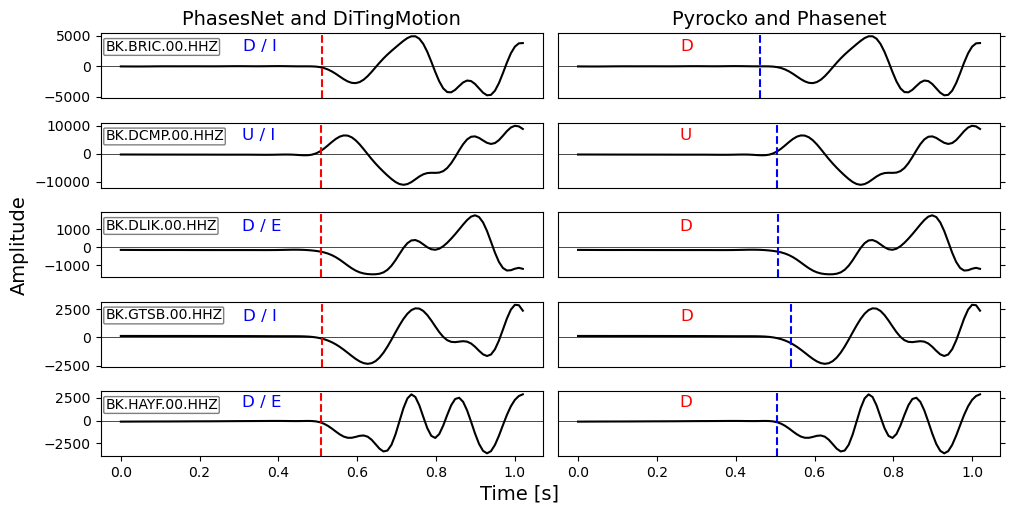

In [3]:
from my_funcs.my_class_funcs import WaveformPlotter

wfp = WaveformPlotter()
fig = wfp.plotWFpick_subplots(sel_ev, pol_df, waveform_dir, n_subplots=5, slice_len=0.5)
plt.tight_layout()
plt.show()  

# One subplot for all stations

In [4]:
def WFprocessing(
    stn_id : str,
    pn_pick : UTCDateTime,
    st : Stream,
    sli : float = 0.5,
    normalize : bool = False,
):
    """ 
    Check for empty trace, detrend, taper, filter.
    Slice the trace around the PhasesNet pick.

    output: trace
    """ 
    ist = st.select(id=stn_id)
    tr = ist[0].copy()

    # check for empty trace
    if len(tr.data) > 0:
        tr.detrend('demean')
        try:
            tr.detrend('linear')
        except:
            tr.detrend('constant')
        
        try:
            tr.taper(0.001)
            tr.filter('bandpass', freqmin=.1, freqmax=10, corners=4, zerophase=True)  # Apply a bandpass filter
        except:
            pass
        
        if normalize:
            tr.data = tr.data/np.max(tr.data)
        # slice the trace
        tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick

        return tr

In [5]:
def plotWFpick_oneplot(
                        mseed_file = None,
                        pol_df = None,
                        waveform_dir = None,
                        n_subplots=10, 
                        slice_len=0.5,
                        zoom=3,
                        normalize: bool = True,
                        hor_line: bool = True,
                        ):

    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        return None

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    # read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    ax1, ax2 = axs

    for i, row in event_df[0:n_subplots].iterrows():

        # get the pick times (PhasesNet and Pyrocko)
        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        # get the trace for this station
        stn_id = f'{row.station_id}Z'

        # Process the waveform using the WFprocessing function
        tr = WFprocessing(stn_id, pn_pick, st, slice_len, normalize)
        
        if not len(tr.data) > 0: # check if the trace is empty
            continue
    
        # Generate time axis as a numpy array
        times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts) # time [s]

        # get the pick time from starttime into seconds
        pn_pick_time = ((pn_pick - tr.stats.starttime)) 
        pr_pick_time = ((pr_pick - tr.stats.starttime)) 
        
        # get polarity
        dting_pol = row.diting_polarity
        dting_sharp = row.diting_sharpness
        prk_pol = row.pyrocko_polarity
        
        ###### COLUMN 1: PhasesNet pick, DiTing polarity ######
        #######################################################
        ax1.plot(times, tr.data*zoom + i, 'k')     # plot the waveform
        ax1.plot([pn_pick_time, pn_pick_time], [i-0.8, i+0.8], color='r', ls='--')      # PhasesNet pick
        # Polarity and sharpness (DiTing)
        ax1.text(
            pn_pick_time-0.15, i + 0.5, 
            f"{dting_pol} / {dting_sharp}", 
            fontsize=12, color='b', ha='left')

        # title [station_id] and horizontal line at 0
        ax1.text( 
            pn_pick_time-0.5,
            i - 0.3, 
            f"{tr.id}",
            fontsize=8)
            

        ###### COLUMN 2: Pyrocko pick, Pyrocko polarity ######
        #######################################################
        ax2.plot(times, tr.data * zoom +i, 'k')    # plot the waveform
        ax2.plot([pr_pick_time, pr_pick_time], [i-0.8, i+0.8], color='b', ls='--')   # Pyrocko pick [manual + phasenet]
        # Polarity (Pyrocko)
        ax2.text(
            pn_pick_time-0.25,  i + 0.5,
            f"{'U' if prk_pol == 1 else 'D'}", 
            fontsize=12, color='r',)

        ## Optional plotting parameters ##
        if hor_line:
            ax1.plot([0, 1], [i, i], color='k', lw=0.5)
            ax2.plot([0, 1], [i, i], color='k', lw=0.5)


    # # add one title for each column
    ax1.set_title('PhasesNet and DiTingMotion', fontsize=14)
    ax2.set_title('Pyrocko and Phasenet', fontsize=14)
    
    # plot axes (one for both columns)
    ax1.set_ylabel('Amplitude', fontsize=12)
    plt.xlabel('Time [s]',x=-.05, y=0.01, fontsize=12)

    return fig, axs

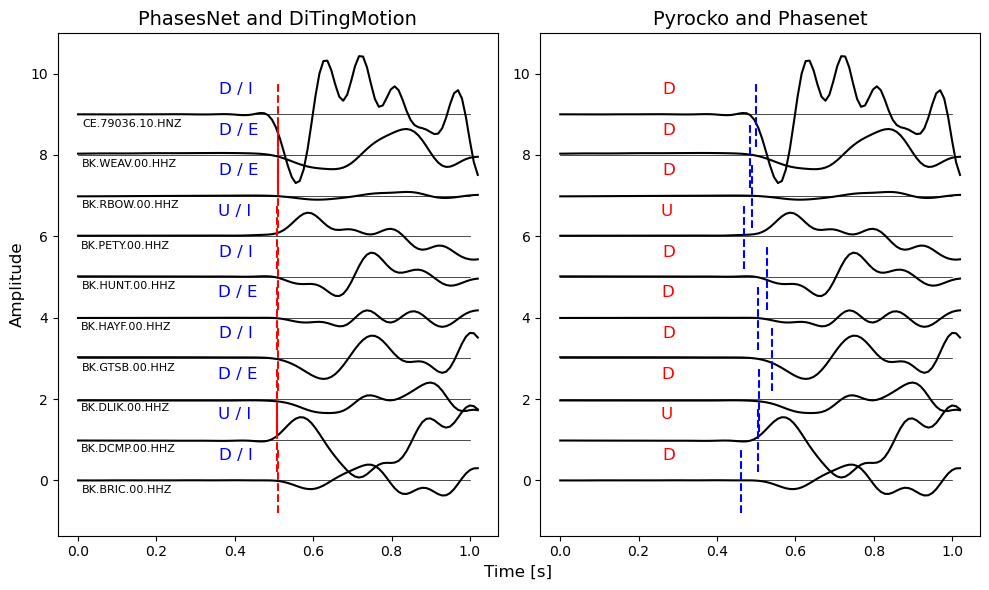

In [18]:
mseed_file = 'nc73783911.mseed'

fig, axs = plotWFpick_oneplot(mseed_file, pol_df, waveform_dir, 
                        n_subplots=10, 
                        slice_len=0.5, 
                        zoom=3, 
                        normalize=True,
                        hor_line=True)

ax1.set_title('PhasesNet and DiTingMotion test', fontsize=14)
plt.tight_layout()
plt.show()

### Using class function:

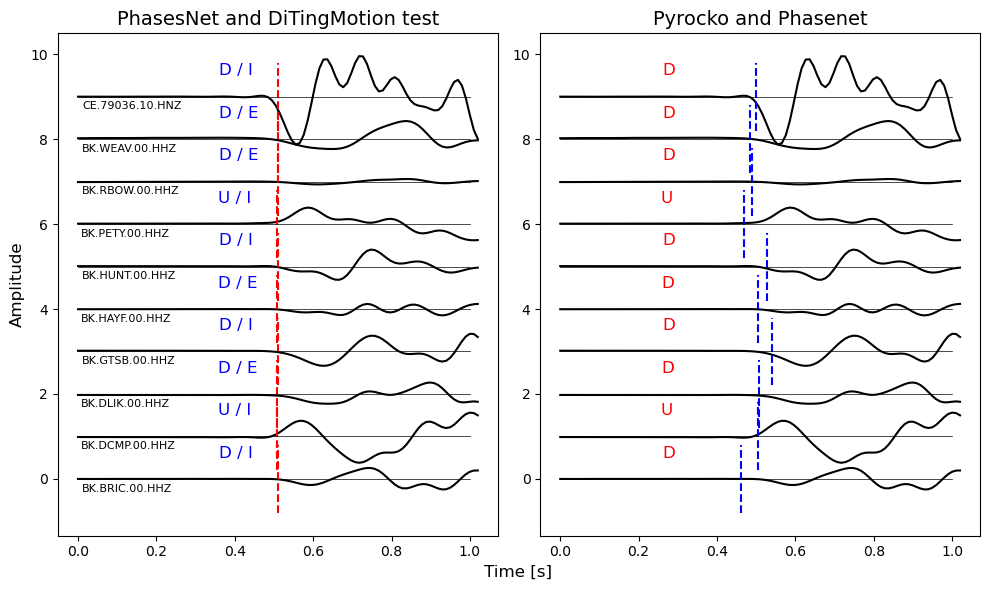

In [16]:
from my_funcs.my_class_funcs import WaveformPlotter
%reload_ext autoreload
%autoreload 2

wfp = WaveformPlotter()
fig, [ax1, ax2] = wfp.plotWFpick_oneplot(
    mseed_file = 'nc73783911.mseed',
    pol_df = pol_df,
    waveform_dir = waveform_dir,
    n_subplots=10, 
    slice_len=0.5,
    zoom=2,
    normalize = True,
    hor_line = True,
)
ax1.set_title('PhasesNet and DiTingMotion test', fontsize=14)
plt.tight_layout()
plt.show()